In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

\begin{align}
u_{xx} &= h_x^{-2}(u_{i-1,j}-2u_{i,j}+u_{i+1,j}) \\
u_{yy} &= h_y^{-2}(u_{i,j-1}-2u_{i,j}+u_{i,j+1}) \\
\end{align}

if $h_x = h_y$

\begin{align}
u_{xx} + u_{yy} = h_x^{-2}(u_{i-1,j}-2u_{i,j}+u_{i+1,j}) + h_y^{-2}(u_{i,j-1}-2u_{i,j}+u_{i,j+1}) \\
u_{xx} + u_{yy} = h^{-2}[(u_{i-1,j}-2u_{i,j}+u_{i+1,j}) + (u_{i,j-1}-2u_{i,j}+u_{i,j+1})] \\
u_{xx} + u_{yy} = \frac{u_{i-1,j}+u_{i+1,j} -4u_{i,j} + u_{i,j-1}+u_{i,j+1}}{h^{2}}
\end{align}

if $h_x \neq h_y$

\begin{align}
u_{xx} + u_{yy} = h_x^{-2}(u_{i-1,j}-2u_{i,j}+u_{i+1,j}) + h_y^{-2}(u_{i,j-1}-2u_{i,j}+u_{i,j+1}) \\
u_{xx} + u_{yy} = \frac{h_y^{2}(u_{i-1,j}-2u_{i,j}+u_{i+1,j}) + h_x^{2}(u_{i,j-1}-2u_{i,j}+u_{i,j+1})}{h_x^2h_y^2} \\
\end{align}

In [ ]:
def matrix_Ab(grid):

  u_numbery = (len(grid)-2)
  u_numberx = (len(grid[0])-2)
  A = np.full((u_numberx*u_numbery, u_numberx * u_numbery), 0)
  b = np.full(u_numberx*u_numbery, 0)

  u_range_y = np.arange(1, u_numbery + 1)
  u_range_x = np.arange(1, u_numberx + 1)

  k = 0
  for i in u_range_y:
    for j in u_range_x:

      A[k][k] = 4

      for l in [-1,1]:
        shift_x = j + l

        if shift_x in u_range_x:
          A[k][k + l]  = -1
        else:
          b[k] += grid[i][shift_x]

      for l in [-1,1]:
        shift_y = i + l
        if shift_y in u_range_y:
          A[k][k + u_numbery*l]  = -1
        else:
          b[k] += grid[shift_y][j]

      k += 1
  return A, b

In [ ]:
h = 5
x_size = 20 // 5 + 1
y_size = 10 // 5 + 1

stencil = np.full((y_size, x_size), 0)

for i in range(1,y_size-1):
  stencil[i][-1] = 100

A, b = matrix_Ab(stencil)


L, U, D = np.tril(A, -1), np.triu(A, 1), np.diag(np.diag(A))


invD = scipy.linalg.inv(D)

LU_sub = -L-U
C = np.matmul(invD, LU_sub)
d = invD * b

In [ ]:
def jacobiMethod2(grid, m = 10, error = 1e-8, error_find = False):
  A, b = matrix_Ab(grid)
  L, U, D = np.tril(A, -1), np.triu(A, 1), np.diag(np.diag(A))

  invD = scipy.linalg.inv(D)

  LU_sub = -L-U
  C = np.matmul(invD, LU_sub)
  d = np.matmul(invD,b)

  u = np.zeros(len(b))

  count = 0
  if error_find:
    current_error = 1
    while current_error > error:
      u = np.matmul(C, u) + d
      current_error = np.max(np.matmul(A, u) - b)
      count += 1

  else:
    for i in range(m):
      u = np.matmul(C, u) + d
    count = m

  solved_grid = grid.copy()
  k = 0
  for i in range(1, len(grid)-1):
    for j in range(1, len(grid[0])-1):
      solved_grid[i][j] = u[k]
      k += 1

  return solved_grid, count

In [ ]:
solution_2 = jacobiMethod2(stencil, m=40)
print(solution_2)

(array([[  0,   0,   0,   0,   0],
       [  0,   1,   7,  26, 100],
       [  0,   0,   0,   0,   0]]), 40)


Text(0, 0.5, 'Y')

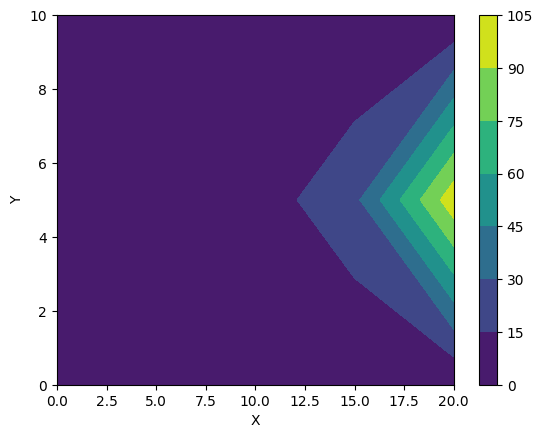

In [ ]:
x = np.arange(0, 21, 5)
y = np.arange(0, 11, 5)

X, Y = np.meshgrid(x,y)

plt.contourf(X,Y, solution_2[0])
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")

In [ ]:
solutions = []

h = [5/2, 5/4, 5/8, 5/16]

for i in h:
  x_size = round(20 // i + 1)
  y_size = round(10 // i + 1)

  stencil = np.full((y_size, x_size), 0)

  for i in range(1,y_size-1):
    stencil[i][-1] = 100

  solutions.append(jacobiMethod2(stencil, error_find=True)[0])


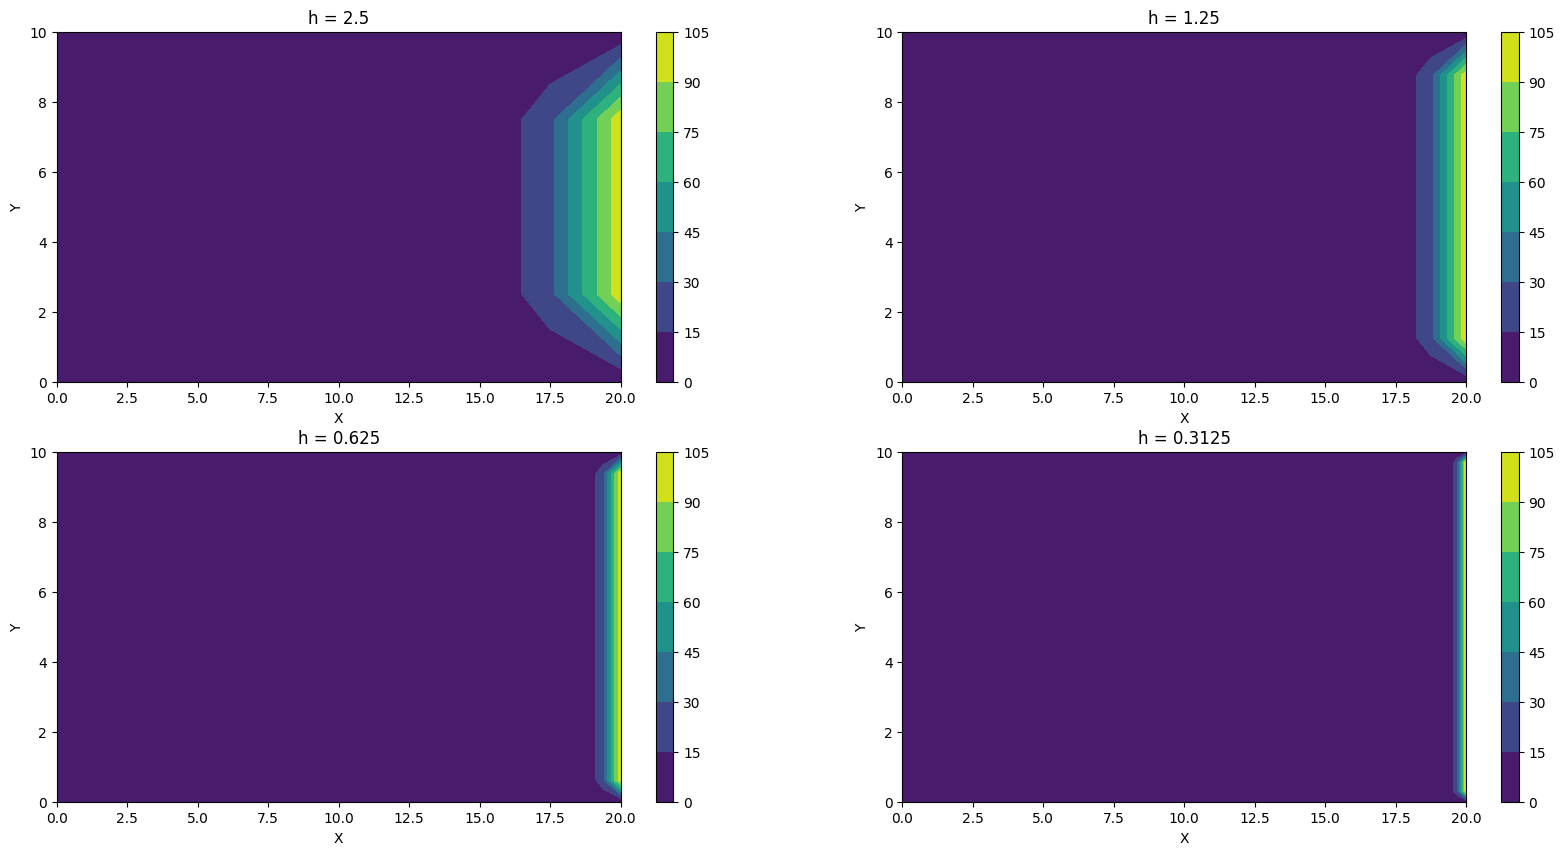

In [ ]:
fig = plt.figure(figsize=(20, 10))

for i, j in enumerate(h):
  x = np.arange(0, 20.1, j)
  y = np.arange(0, 10.1, j)

  X, Y = np.meshgrid(x,y)

  ax = fig.add_subplot(2, 2, i+1)
  contour = ax.contourf(X,Y, solutions[i])
  fig.colorbar(contour)
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_title("h = " + str(j))




In [ ]:
def gaussSeidel2(grid, m = 10, error = 1e-8, error_find = False):
  A, b = matrix_Ab(grid)
  L, U, D = np.tril(A, -1), np.triu(A, 1), np.diag(np.diag(A))


  DL_inv = scipy.linalg.inv(D+L)

  u = np.zeros(len(b))

  count = 0
  if error_find:
    current_error = 1
    while current_error > error:
      u = np.matmul(DL_inv,np.matmul(-U, u)+b)
      current_error = np.max(np.matmul(A, u) - b)
      count += 1

  else:
    for i in range(m):
      u = np.matmul(DL_inv,np.matmul(-U, u)+b)
    count = m

  solved_grid = grid.copy()
  k = 0
  for i in range(1, len(grid)-1):
    for j in range(1, len(grid[0])-1):
      solved_grid[i][j] = u[k]
      k += 1

  return solved_grid, count

In [ ]:
x_size = 64
y_size = 64

x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)

stencil = np.full((x_size, y_size), 0)

for i in range(1,x_size-1):
  stencil[0][i] = 100 * np.sin(2 * np.pi * x[i])

for i in range(1,x_size-1):
  stencil[-1][i] = - 100 * np.sin(2 * np.pi * x[i])

data_jac, itteration_jac = jacobiMethod2(stencil, error_find=True)
data_gaus, itteration_gaus = gaussSeidel2(stencil, error_find=True)

Text(0.5, 1.0, 'Gauss-Seidel Method')

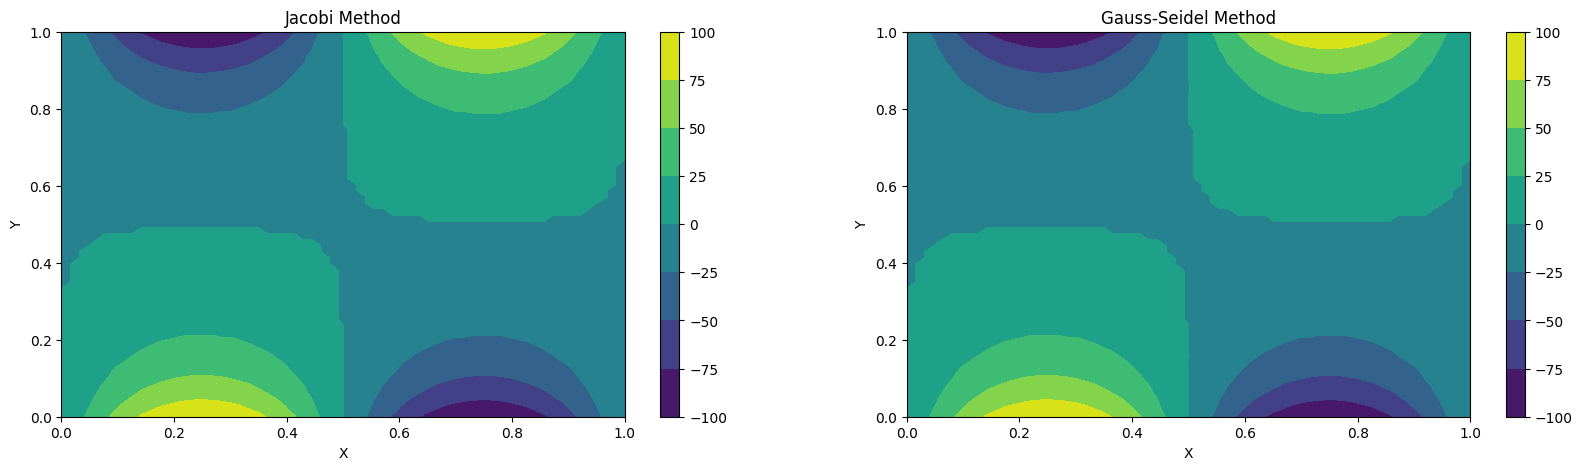

In [ ]:
fig = plt.figure(figsize=(20, 5))



X, Y = np.meshgrid(x,y)

ax = fig.add_subplot(1, 2, 1)
contour = ax.contourf(X,Y, data_jac)
fig.colorbar(contour)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Jacobi Method")

ax = fig.add_subplot(1, 2, 2)
contour = ax.contourf(X,Y, data_gaus)
fig.colorbar(contour)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Gauss-Seidel Method")

In [ ]:
print("Number of Itterations till convergence for Jacobi Method " + str(itteration_jac))
print("Number of Itterations till convergence for Gauss-Seidel Method " + str(itteration_gaus))

Number of Itterations till convergence for Jacobi Method 8768
Number of Itterations till convergence for Gauss-Seidel Method 1713


In [ ]:
def matrix_Ab_2(grid, alpha):

  u_numbery = (len(grid)-2)
  u_numberx = (len(grid[0])-2)
  A = np.full((u_numberx*u_numbery, u_numberx * u_numbery), 0)
  b = np.full(u_numberx*u_numbery, 0)

  u_range_y = np.arange(1, u_numbery + 1)
  u_range_x = np.arange(1, u_numberx + 1)

  k = 0
  for i in u_range_y:
    for j in u_range_x:

      A[k][k] = 4 + alpha

      for l in [-1,1]:
        shift_x = j + l

        if shift_x in u_range_x:
          A[k][k + l]  = -1
        else:
          b[k] += grid[i][shift_x]

      for l in [-1,1]:
        shift_y = i + l
        if shift_y in u_range_y:
          A[k][k + u_numbery*l]  = -1
        else:
          b[k] += grid[shift_y][j]

      k += 1
  return A, b

In [ ]:
x_size = 50
y_size = 50

grid_schro = np.zeros((50,50))

for i in range(0,x_size):
  grid_schro[0][i] = 1

for i in range(0,x_size):
  grid_schro[-1][i] = 1

for i in range(1,y_size-1):
  grid_schro[i][-1] = 1

for i in range(1,y_size-1):
  grid_schro[i][0] = 1

In [ ]:
A_schro, b_schro = matrix_Ab_2(grid_schro, 1)

solved_grid_schro = grid_schro.copy()

x_schro  = np.linalg.solve(A_schro, b_schro)
k = 0
for i in range(1, len(grid_schro)-1):
  for j in range(1, len(grid_schro[0])-1):
    solved_grid_schro[i][j] = x_schro[k]
    k += 1

In [ ]:
x = np.linspace(0,1, x_size)
y = np.linspace(0, 1, y_size)

X, Y = np.meshgrid(x,y)


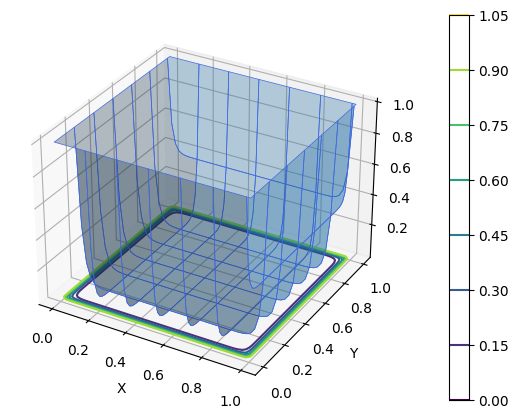

In [ ]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, solved_grid_schro,edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

p = ax.contour(X, Y, solved_grid_schro, offset=0)


# Add color bar
cb = fig.colorbar(p)


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')


# Show plot
plt.show()

In [ ]:
def weightedJacobiMethod2(grid, w, a,m = 10, error = 1e-8, error_find = False):
  A, b = matrix_Ab_2(grid, a)
  L, U, D = np.tril(A, -1), np.triu(A, 1), np.diag(np.diag(A))

  invD = scipy.linalg.inv(D)

  LU_sub = -L-U
  C = np.matmul(invD, LU_sub)
  d = np.matmul(invD,b)

  u = np.zeros(len(b))

  count = 0
  if error_find:
    current_error = 1
    while current_error > error:
      u = w * (np.matmul(C, u) + d) + (1- w) * u
      current_error = np.max(np.matmul(A, u) - b)
      count += 1

  else:
    for i in range(m):
      u = w * (np.matmul(C, u) + d) + (1- w) * u
    count = m

  solved_grid = grid.copy()
  k = 0
  for i in range(1, len(grid)-1):
    for j in range(1, len(grid[0])-1):
      solved_grid[i][j] = u[k]
      k += 1

  return solved_grid, count

In [ ]:
w = [0.1,0.25,0.5,0.75, 0.9]
schro_data = []
for i in w:
  schro_data.append(weightedJacobiMethod2(grid_schro, i, 1,error_find = True)[0])


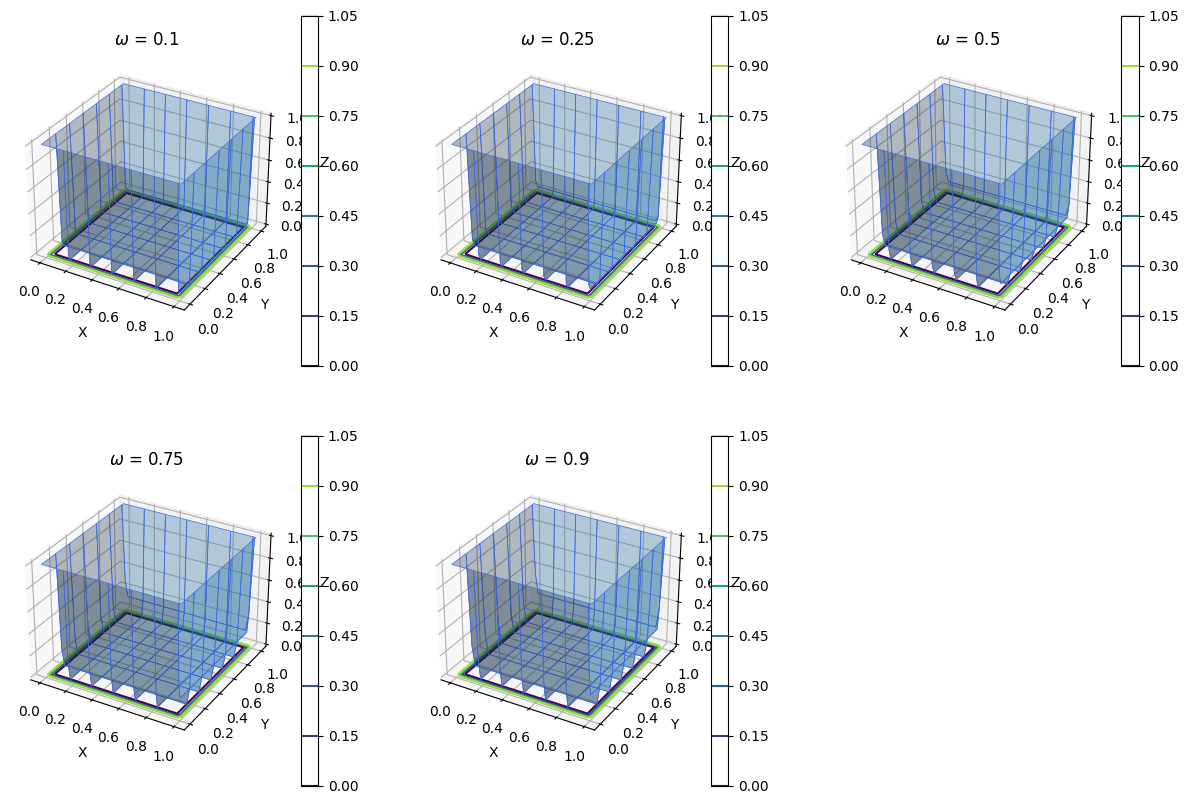

In [ ]:
fig = plt.figure(figsize=(15, 10))

for i in range(len(schro_data)):
  ax = fig.add_subplot(2, 3, i+1, projection='3d')
  ax.plot_surface(X, Y, schro_data[i],edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
  p = ax.contour(X, Y, schro_data[i], offset=0)


  # Add color bar
  cb = fig.colorbar(p)

  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")
  ax.set_title("$\omega$ = " + str(w[i]))



plt.show()

In [ ]:
A_schro, b_schro = matrix_Ab_2(grid_schro, 1000)

solved_grid_schro = grid_schro.copy()

x_schro  = np.linalg.solve(A_schro, b_schro)
k = 0
for i in range(1, len(grid_schro)-1):
  for j in range(1, len(grid_schro[0])-1):
    solved_grid_schro[i][j] = x_schro[k]
    k += 1

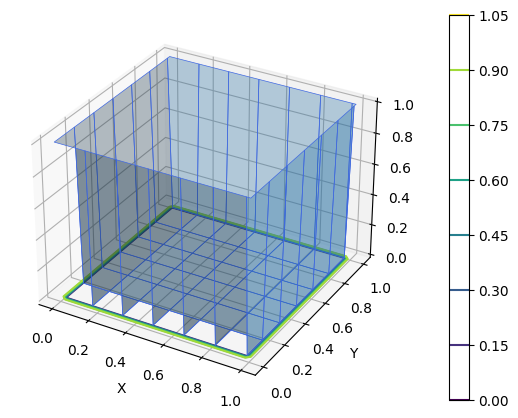

In [ ]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, solved_grid_schro,edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

p = ax.contour(X, Y, solved_grid_schro, offset=0)


# Add color bar
cb = fig.colorbar(p)


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')


# Show plot
plt.show()

In [ ]:
w = [0.1,0.25,0.5,0.75, 0.9]
schro_data = []
for i in w:
  schro_data.append(weightedJacobiMethod2(grid_schro, i, 1000,error_find = True)[0])


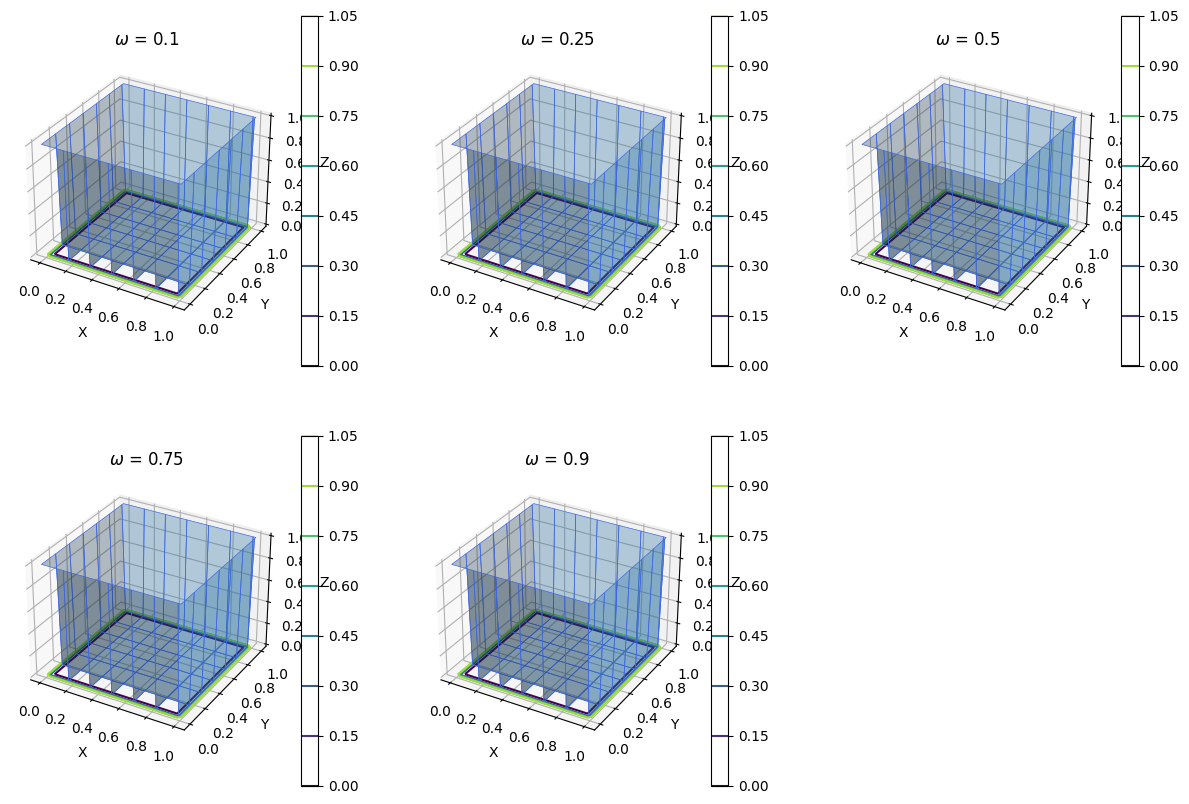

In [ ]:
fig = plt.figure(figsize=(15, 10))

for i in range(len(schro_data)):
  ax = fig.add_subplot(2, 3, i+1, projection='3d')
  ax.plot_surface(X, Y, schro_data[i],edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
  p = ax.contour(X, Y, schro_data[i], offset=0)


  # Add color bar
  cb = fig.colorbar(p)

  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")
  ax.set_title("$\omega$ = " + str(w[i]))



plt.show()

In [ ]:
def forwardEuler(u, r):
  A = np.zeros((len(u), len(u)))
  for i in range(len(A)):
    if i > 0 and i < len(u)-1:
      A[i][i+1] = 1/2 * r
      A[i][i-1] = -1/2 * r
      A[i][i] = 1
    elif i == 0:
      A[i][i] = 1
      A[i][i+1] = 1/2 * r
    elif i == len(u) - 1:
      A[i][i] = 1
      A[i][i-1] = -1/2 * r

  b = np.zeros(len(u))

  b[0] = - 1 / 2 * r
  b[-1] = 1 / 2 * r

  return np.matmul(A, u) + b



In [ ]:
dt_list = [0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.04]
dx_list = [0.04, 0.02, 0.0137, 0.0101, 0.099, 0.02, 0.02]
r_list = [0.25, 0.5, 0.728, 0.99, 1.11, 0.25, 1]

def sin_initial(x):
  return np.sin(2 * x)

def exp_initial(x):
  return np.exp(-4*x**2)

data_1 = []
data_2 = []

for dt, dx, r in zip(dt_list, dx_list, r_list):
  t_range = np.arange(0, 2, dt)
  x_range = np.arange(-2, 2, dx)

  data_temp1 = np.zeros((len(t_range), len(x_range)))

  data_temp1[0] = sin_initial(x_range)

  for i in range(1, len(data_temp1)):
    data_temp1[i] = forwardEuler(data_temp1[i-1], r)
  
  data_1.append(data_temp1)

  data_temp2 = np.zeros((len(t_range), len(x_range)))

  data_temp2[0] = exp_initial(x_range)

  for i in range(1, len(data_temp2)):
    data_temp2[i] = forwardEuler(data_temp2[i-1], r)

  data_2.append(data_temp2)


TypeError: ignored

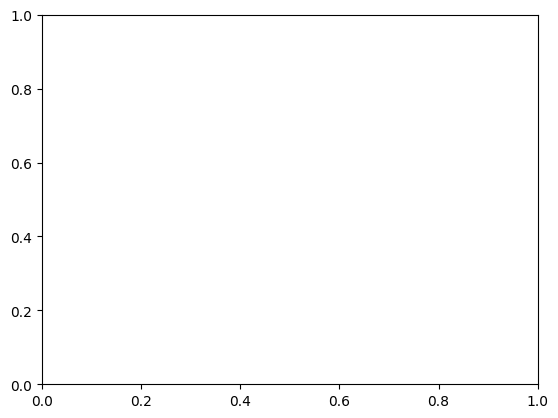

In [ ]:
t_range = np.arange(0, 2, 0.02)
x_range = np.arange(-2, 2, 0.04)

X, T = np.meshgrid(x_range,t_range)

plt.contourf(X,Y, data_1[0])
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")